Работу выполнил Данил Исламов (Stepik ID: 274397404)

<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

# Embeddings

Привет! В этом домашнем задании мы с помощью эмбеддингов решим задачу семантической классификации твитов.

Для этого мы воспользуемся предобученными эмбеддингами word2vec.

Для начала скачаем датасет для семантической классификации твитов:

In [ ]:
!gdown https://drive.google.com/uc?id=1eE1FiUkXkcbw0McId4i7qY-L8hH-_Qph&export=download
!unzip archive.zip

Downloading...
From: https://drive.google.com/uc?id=1eE1FiUkXkcbw0McId4i7qY-L8hH-_Qph
To: /content/archive.zip
84.9MB [00:01, 79.7MB/s]
Archive:  archive.zip
  inflating: training.1600000.processed.noemoticon.csv  


Импортируем нужные библиотеки:

In [ ]:
import math
import random
import string

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import nltk
import gensim
import gensim.downloader as api

from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

In [ ]:
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin", header=None, names=["emotion", "id", "date", "flag", "user", "text"])

Посмотрим на данные:

In [ ]:
data.head()

,emotion,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Посмотрим, сбалансированы ли классы

In [ ]:
data.emotion.value_counts()

4    800000
0    800000
Name: emotion, dtype: int64

Выведем несколько примеров твитов, чтобы понимать, с чем мы имеем дело:

In [ ]:
examples = data["text"].sample(10)
print("\n".join(examples))

@chrishasboobs AHHH I HOPE YOUR OK!!! 
@misstoriblack cool , i have no tweet apps  for my razr 2
@TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
upper airways problem 
Going to miss Pastor's sermon on Faith... 
on lunch....dj should come eat with me 
@piginthepoke oh why are you feeling like that? 
gahh noo!peyton needs to live!this is horrible 
@mrstessyman thank you glad you like it! There is a product review bit on the site  Enjoy knitting it!


Как видим, тексты твитов очень "грязные". Нужно предобработать датасет, прежде чем строить для него модель классификации.

Чтобы сравнивать различные методы обработки текста/модели/прочее, разделим датасет на dev(для обучения модели) и test(для получения качества модели).

In [ ]:
indexes = np.arange(data.shape[0])
np.random.shuffle(indexes)
dev_size = math.ceil(data.shape[0] * 0.8)

dev_indexes = indexes[:dev_size]
test_indexes = indexes[dev_size:]

dev_data = data.iloc[dev_indexes]
test_data = data.iloc[test_indexes]

dev_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

## Обработка текста

Токенизируем текст, избавимся от знаков пунктуации и выкинем все слова, состоящие менее чем из 4 букв:

Одним из результатов предыдущего ДЗ стало то, что при использовании предобученных эмбеддингов добавление стемминга в токенизатор может ухудшить качество, а удаление с его помощью стоп-слов не имеет смысла, т.к. они и так отсутствуют в словаре эмбеддингов (что было бы логично) или имеют (почти?) нулевой вектор. Поэтому будем просто дробить тексты на отдельные слова, после чего выкидывать пунктуацию и слишком короткие слова

In [ ]:
tokenizer = nltk.WordPunctTokenizer()
line = tokenizer.tokenize(dev_data["text"][0].lower())
print(" ".join(line))

@ claire_nelson i ' m on the north devon coast the next few weeks will be down in devon again in may sometime i hope though !


In [ ]:
filtered_line = [w for w in line if all(c not in string.punctuation for c in w) and len(w) > 3]
print(" ".join(filtered_line))

north devon coast next weeks will down devon again sometime hope though


Загрузим предобученную модель эмбеддингов. 

Если хотите, можно попробовать другую. Полный список можно найти здесь: https://github.com/RaRe-Technologies/gensim-data.

Данная модель выдает эмбеддинги для **слов**. Строить по эмбеддингам слов эмбеддинги предложений мы будем ниже.

In [ ]:
word2vec = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
emb_line = [word2vec.get_vector(w) for w in filtered_line if w in word2vec]
print(sum(emb_line).shape)

(300,)


Нормализуем эмбеддинги, прежде чем обучать на них сеть. 
(наверное, вы помните, что нейронные сети гораздо лучше обучаются на нормализованных данных)

In [ ]:
mean = np.mean(word2vec.vectors, 0)
std = np.std(word2vec.vectors, 0)
norm_emb_line = [(word2vec.get_vector(w) - mean) / std for w in filtered_line if w in word2vec and len(w) > 3]
print(sum(norm_emb_line).shape)
print([all(norm_emb_line[i] == emb_line[i]) for i in range(len(emb_line))])

(300,)
[False, False, False, False, False, False, False, False, False, False, False, False]


Сделаем датасет, который будет по запросу возвращать подготовленные данные.

In [ ]:
from torch.utils.data import Dataset, random_split


class TwitterDataset(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec):
        self.tokenizer = nltk.WordPunctTokenizer()
        
        self.data = data

        self.feature_column = feature_column
        self.target_column = target_column

        self.word2vec = word2vec

        self.label2num = lambda label: 0 if label == 0 else 1
        self.mean = np.mean(word2vec.vectors, axis=0)
        self.std = np.std(word2vec.vectors, axis=0)

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"feature": embeddings, "target": label}

    def get_tokens_(self, text):
        # Получаем все токены из текста и фильтруем их
        tokens = self.tokenizer.tokenize(text.lower())
        filtered_tokens = [t for t in tokens if all(c not in string.punctuation 
                                                    for c in t) and len(t) > 3]
        return filtered_tokens

    def get_embeddings_(self, tokens):
        # Получаем эмбеддинги слов и нормализуем их
        embeddings = [(self.word2vec.get_vector(t) - self.mean) / self.std 
                      for t in tokens if t in self.word2vec and len(t) > 3]

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(1, -1)

        return embeddings

    def __len__(self):
        return self.data.shape[0]

In [ ]:
dev = TwitterDataset(dev_data, "text", "emotion", word2vec)

Отлично, мы готовы с помощью эмбеддингов слов превращать твиты в векторы и обучать нейронную сеть.

Превращать твиты в векторы, используя эмбеддинги слов, можно несколькими способами. А именно такими:

## Average embedding (2 балла)
---
Это самый простой вариант, как получить вектор предложения, используя векторные представления слов в предложении. А именно: вектор предложения есть средний вектор всех слов в предложении (которые остались после токенизации и удаления коротких слов, конечно). 

In [ ]:
indexes = np.arange(len(dev))
np.random.shuffle(indexes)
example_indexes = indexes[::1000]

examples = {"features": [np.mean(dev[i]["feature"], axis=0) for i in example_indexes], 
            "targets": [dev[i]["target"] for i in example_indexes]}
print(len(examples["features"]))

1280


Давайте сделаем визуализацию полученных векторов твитов тренировочного (dev) датасета. Так мы увидим, насколько хорошо твиты с разными target значениями отделяются друг от друга, т.е. насколько хорошо усреднение эмбеддингов слов предложения передает информацию о предложении.

Для визуализации векторов надо получить их проекцию на плоскость. Сделаем это с помощью `PCA`. Если хотите, можете вместо PCA использовать TSNE: так у вас получится более точная проекция на плоскость (а значит, более информативная, т.е. отражающая реальное положение векторов твитов в пространстве). Но TSNE будет работать намного дольше.

In [ ]:
# Обучаем PCA на эмбеддингах слов
pca = PCA(n_components=2)
examples["transformed_features"] = pca.fit_transform(examples["features"])

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
draw_vectors(
    examples["transformed_features"][:, 0], 
    examples["transformed_features"][:, 1], 
    color=[["red", "blue"][t] for t in examples["targets"]]
    )

Figure(id='1002', ...)

Скорее всего, на визуализации нет четкого разделения твитов между классами. Это значит, что по полученным нами векторам твитов не так-то просто определить, к какому классу твит принадлежит. Значит, обычный линейный классификатор не очень хорошо справится с задачей. Надо будет делать глубокую (хотя бы два слоя) нейронную сеть.

Подготовим загрузчики данных.
Усреднее векторов будем делать в "батчевалке"(`collate_fn`). Она используется для того, чтобы собирать из данных `torch.Tensor` батчи, которые можно отправлять в модель.


In [ ]:
from torch.utils.data import DataLoader


batch_size = 1024
num_workers = 4

def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}


train_size = math.ceil(len(dev) * 0.8)

train, valid = random_split(dev, [train_size, len(dev) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

Определим функции для тренировки и теста модели:

In [ ]:
from tqdm.notebook import tqdm


def training(model, optimizer, criterion, train_loader, epoch, device="cpu"):
    pbar = tqdm(train_loader, desc=f"Epoch {e + 1}. Train Loss: {0}")
    model.train()
    losses_tr = 0
    for batch in pbar:
        features = batch["features"].to(device)
        targets = batch["targets"].to(device)

        optimizer.zero_grad()

        # Получаем предсказания модели
        y_pred = model(features)
        
        # Считаем лосс
        loss = criterion(y_pred, targets) 
        losses_tr += loss.item()
        
        # Обновляем параметры модели
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {e + 1}. Train Loss: {loss:.4}")
    
    return (losses_tr / len(train_loader))
    

def testing(model, criterion, test_loader, device="cpu"):
    pbar = tqdm(test_loader, desc=f"Test Loss: {0}, Test Acc: {0}")
    mean_loss = 0
    mean_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in pbar:
            features = batch["features"].to(device)
            targets = batch["targets"].to(device)
            
            # Получаем предсказания модели
            y_pred = model(features).detach()
            
            # Считаем лосс
            loss = criterion(y_pred, targets)
            
            # Считаем точность модели
            acc = torch.sum(torch.argmax(y_pred, dim=1) == targets).float() / batch_size

            mean_loss += loss.item()
            mean_acc += acc.item()

            pbar.set_description(f"Test Loss: {loss:.4}, Test Acc: {acc:.4}")

    pbar.set_description(f"Test Loss: {mean_loss / len(test_loader):.4}, Test Acc: {mean_acc / len(test_loader):.4}")

    return (mean_loss / len(test_loader)), {"Test Loss": mean_loss / len(test_loader), "Test Acc": mean_acc / len(test_loader)}

Создадим модель, оптимизатор и целевую функцию. Вы можете сами выбрать количество слоев в нейронной сети, ваш любимый оптимизатор и целевую функцию.


In [ ]:
import torch.nn as nn
from torch.optim import Adam

# Возьму гиперпараметры, с помощью которых удалось получить довольно приемлемое качество
vector_size = dev.word2vec.vector_size
num_classes = 2
lr = 1e-4
num_epochs = 2

# Модель
model = nn.Sequential(
    nn.Linear(vector_size, 512),
    nn.ReLU(),
    nn.Linear(512, 300),
    nn.ReLU(),
    nn.Linear(300, num_classes))

model = model.cuda()

# Лосс
criterion = nn.CrossEntropyLoss()

# Оптимизатор
optimizer = Adam(params=model.parameters(), lr=lr) 

Наконец, обучим модель и протестируем её.

После каждой эпохи будем проверять качество модели на валидационной части датасета. Если метрика стала лучше, будем сохранять модель. **Подумайте, какая метрика (точность или лосс) будет лучше работать в этой задаче?** 

Думаю, что в данном случае значение лосса — я использовал кросс-энтропию — является более тонкой и строгой оценкой работы модели, нежели accuracy. Связано это с тем, что для того, чтобы добиться низкого лосса, модель должна не только предсказывать бóльшую вероятность для правильного класса, но и быть относительно уверенной в своих предсказаниях (т.е. предсказанная вероятность правильного класса должа быть как можно больше, а неправильного — как можно меньше). Для того же, чтобы добиться высокой accuracy, достаточно, чтобы модель предсказывала с вероятностью чуть больше 0.5 (здесь я использовал "классический" порог) правильный класс и с вероятностью чуть ниже 0.5 неправильный класс, т.е. выдавала почти случайный результат. 

Конечно, в данной задаче плюсом является то, что классы хорошо сбалансированы — это нивелирует недостаток accuracy в качестве метрики для предсказаний сильно несбалансированных классов (когда можно всегда предсказывать доминирующий класс и получать высокую accuracy), однако я всё равно считаю лосс (кросс-энтропию) более "говорящим" показателем для оценки качества получаемой модели

In [ ]:
best_metric = np.inf
loss_tr = []
loss_test = []
for e in range(num_epochs):
    train_loss = training(model, optimizer, criterion, train_loader, e, device)
    loss_tr.append(train_loss)
    test_loss, log = testing(model, criterion, valid_loader, device)
    loss_test.append(test_loss)
    print(log)
    if log["Test Loss"] < best_metric:
        torch.save(model.state_dict(), "model.pt")
        best_metric = log["Test Loss"]


{'Test Loss': 0.5139521332979202, 'Test Acc': 0.74486328125}



{'Test Loss': 0.5044202452898026, 'Test Acc': 0.750640625}


Посмотрим на графики лоссов

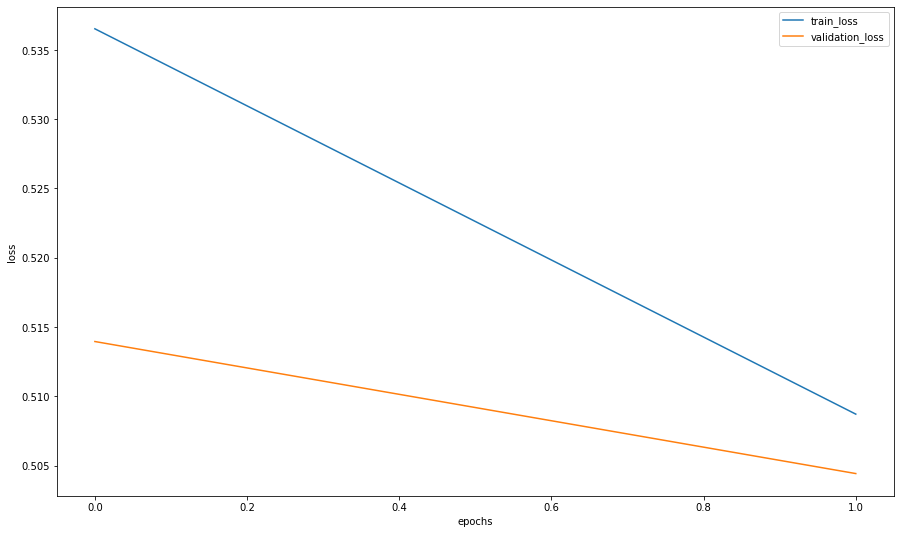

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 9))
plt.plot(loss_tr, label="train_loss")
plt.plot(loss_test, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Переобучения явно нет (да и эпохи было всего 2), при этом лосс быстро сошёлся. При увеличении числа эпох начинается переобучение, поэтому остановлюсь на данном этапе

Посмотрим качество предсказаний лучшей версии модели на тестовом датасете

In [ ]:
test_loader = DataLoader(
    TwitterDataset(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

model.load_state_dict(torch.load("model.pt", map_location=device))

print(testing(model, criterion, test_loader, device=device)[1:])


({'Test Loss': 0.506091662203542, 'Test Acc': 0.7486864766373802},)


## Embeddings for unknown words (8 баллов)

Пока что использовалась не вся информация из текста. Часть информации фильтровалась – если слова не было в словаре эмбеддингов, то мы просто превращали слово в нулевой вектор. Хочется использовать информацию по-максимуму. Поэтому рассмотрим другие способы обработки слов, которых нет в словаре. А именно:

- Для каждого незнакомого слова будем запоминать его контекст(слова слева и справа от этого слова). Эмбеддингом нашего незнакомого слова будет сумма эмбеддингов всех слов из его контекста. (4 балла)
- Для каждого слова текста получим его эмбеддинг из Tfidf с помощью ```TfidfVectorizer``` из [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer). Итоговым эмбеддингом для каждого слова будет сумма двух эмбеддингов: предобученного и Tfidf-ного. Для слов, которых нет в словаре предобученных эмбеддингов, результирующим эмбеддингом будет просто полученный из Tfidf. (4 балла)

Реализуйте оба варианта **ниже**. Напишите, какой способ сработал лучше и ваши мысли, почему так получилось.

### Context Version

Собственно, первый вариант получения эмбеддингов неизвестных слов — будем считать среднее эмбеддингов контекста эмбеддингом данного неизвестного слова (в условии выше предлагается использовать сумму, однако среднее мне кажется более корректным выбором — тогда компоненты искомого эмбеддинга по величине будут примерно того же порядка, что и компоненты эмбеддингов слов контекста). Для этого введём в класс, обрабатывающий наш датасет для дальнейшей работы, новый параметр — window — который будет определять, по сколько слов слева и справа следует брать в качестве контекста. Поскольку хочется узнать примерный смысл конкретного слова, мне кажется, лучше брать окно маленького размера (т.к. окна большого размера скорее подходят для захвата темы, определяемой выбранным набором слов). По умолчанию буду использовать window=2, т.е. будут рассматриваться 2 слова слева и 2 справа.

In [ ]:
class TwitterDatasetUPD1(TwitterDataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, 
                 window: int=2):
        super().__init__(data, feature_column, target_column, word2vec)
        self.window = window

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens, self.window)

        return {"feature": embeddings, "target": label}


    def get_embeddings_(self, tokens, window):
        # Проверяем, что в тексте есть хоть что-то знакомое, дабы не
        # получить далее бесконечную рекурсию
        check = sum([int(t in self.word2vec) for t in tokens])
        if not check:
            return np.zeros((1, self.word2vec.vector_size))
        
        # Получаем эмбеддинги
        embeddings = []        
        for i, t in enumerate(tokens):
            if len(t) > 3:
                if t in self.word2vec:
                    embeddings.append((self.word2vec.get_vector(t) - self.mean) / self.std)
                else:
                    # Не забываем про слова на краях текстов
                    neibs = tokens[max(0, i-window):i] + tokens[i+1:min(len(tokens), i+window+1)]
                    emb = np.mean(self.get_embeddings_(neibs, window), axis=0)
                    # Эмбеддинги неизвестных слов нормализовать отдельно не нужно,
                    # т.к. соседи уже были нормализованы, а среднее нормализованных 
                    # величин тоже является таковым
                    embeddings.append(emb)

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(1, -1)

        return embeddings
        

Создаём датасет нового класса

In [ ]:
dev_upd1 = TwitterDatasetUPD1(dev_data, "text", "emotion", word2vec)

Посмотрим на распределение векторов случайных текстов разных классов

In [ ]:
indexes = np.arange(len(dev_upd1))
np.random.shuffle(indexes)
example_indexes = indexes[::1000]

examples = {"features": [np.mean(dev_upd1[i]["feature"], axis=0) for i in example_indexes], 
            "targets": [dev_upd1[i]["target"] for i in example_indexes]}
print(len(examples["features"]))

1280


In [ ]:
pca = PCA(n_components=2)
examples["transformed_features"] = pca.fit_transform(examples["features"])

In [ ]:
draw_vectors(
    examples["transformed_features"][:, 0], 
    examples["transformed_features"][:, 1], 
    color=[["red", "blue"][t] for t in examples["targets"]]
    )

Figure(id='1002', ...)

Вновь, возможности линейно разделить векторы текстов разных классов не представляется

Обучение модели

In [ ]:
batch_size = 1024
num_workers = 4

def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}

train_size = math.ceil(len(dev_upd1) * 0.8)

train, valid = random_split(dev_upd1, [train_size, len(dev_upd1) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

In [ ]:
# Используем те же параметры, что и для первой модели — данный вариант тоже
# хорошо себя с ними показал, да и сравнение разных подходов так значительно 
# облегчается
vector_size = dev_upd1.word2vec.vector_size
num_classes = 2
lr = 1e-4
num_epochs = 2

model = nn.Sequential(
    nn.Linear(vector_size, 512),
    nn.ReLU(),
    nn.Linear(512, 300),
    nn.ReLU(),
    nn.Linear(300, num_classes))

model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=lr) 

In [ ]:
best_metric = np.inf
loss_tr = []
loss_test = []
for e in range(num_epochs):
    train_loss = training(model, optimizer, criterion, train_loader, e, device)
    loss_tr.append(train_loss)
    test_loss, log = testing(model, criterion, valid_loader, device)
    loss_test.append(test_loss)
    print(log)
    if log["Test Loss"] < best_metric:
        torch.save(model.state_dict(), "model.pt")
        best_metric = log["Test Loss"]


{'Test Loss': 0.5160533427000046, 'Test Acc': 0.74348046875}



{'Test Loss': 0.5069866019487381, 'Test Acc': 0.74899609375}


Посмотрим на графики лоссов

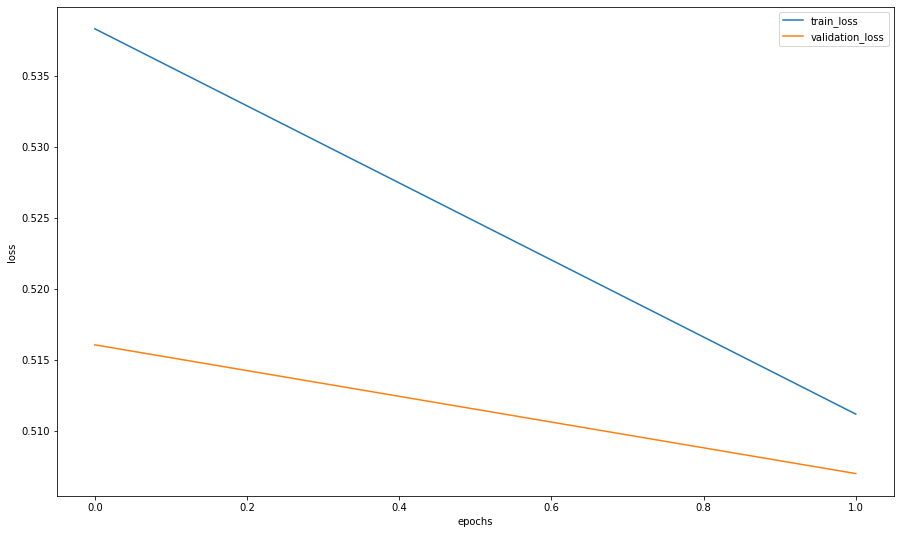

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss_tr, label="train_loss")
plt.plot(loss_test, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Вновь, хоть было всего 2 эпохи, лосс успевает сойтись и при этом модель не переобучается — при увеличении количества эпох переобучение начинает проявляться

Посмотрим качество на тестовом датасете

In [ ]:
test_loader = DataLoader(
    TwitterDataset(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

model.load_state_dict(torch.load("model.pt", map_location=device))

print(testing(model, criterion, test_loader, device=device)[1:])


({'Test Loss': 0.5066267492862555, 'Test Acc': 0.7486147164536742},)


### TF-IDF Version

Поскольку матрица TF-IDF имеет размерность (кол-во текстов, кол-во слов), размерность вектора каждого слова равна количеству текстов, что намного больше размерности эмбеддингов из Word2Vec. Из-за размера матрицы сжать её какими-либо методами вроде PCA или SVD у меня не получилось — при загрузке матрицы даже по батчам (что, например, предполагает метод Incremental PCA) память очень быстро переполнялась.

Тем не менее, можно несколько уменьшить размерность матрицы, т.к. TfidfVectorizer имеет параметр max_features, выбирающий только наиболее часто встречаемые слова. Однако, это не совсем то, что требуется для решения задачи — хотелось бы сократить количество строк (т.е. рассмотренных текстов) матрицы, чтобы вектора слов имели нужную размерность, и при этом сами слова не терялись. Для этого попробуем реализовать идею фильтрования TF-IDF матрицы по строкам по аналогии с использованием max_features.

Подумаем, какие строки можно выкинуть. Матрица TF-IDF получается очень разреженной, поскольку множество слов, содержащихся в конкретном тексте, гораздо меньше всего словаря. Соответственно, самые заполненные строки будут соответствовать тем текстам, в которых наблюдалось наибольшее разнообразие слов. Скорее всего, такие тексты были также достаточно большой длины (вновь-таки, поскольку в них было относительно много разных слов, которые при этом составлены в связный текст). Возможно, стоит отсортировать строки матрицы по убыванию количества ненулевых элементов в них, после чего взять верхушку нужного размера. Таким образом как раз будут захвачены самые разнообразные по используемым словам и (скорее всего) достаточно длинные тексты.

Выдвину следующую гипотезу: использование такой выборки текстов является довольно естественным, т.к. в неё, скорее всего, попадут те тексты, которые содержат основной "костяк" словаря (векторы редких слов должны быть сильно разрежены, так что много информации потеряться не должно), и при этом, за счёт достаточно большого размера отобранных текстов, их векторы позволят неплохо оценить важность конкретного слова во всём используемом корпусе. [Конец гипотезы]

После того, как нужное количество текстов будет отобрано, можно транспонировать TF-IDF матрицу и доставать из неё вектор нужного слова по его индексу (словарь, сопоставляющий слово его индексу можно получить по атрибуту .vocabulary_ класса TfidfVectorizer)

Таким образом, в данной модели будем получать вектор слова из матрицы TF-IDF описанным выше методом, затем складывать его с эмбеддингом из Word2Vec (если таковой имеется), а дальше всё как в первой модели — для получения вектора текста усредняем вектора содержащихся в нём слов, после чего непосредственно обучаемся. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Прописываем проход токенизатора и фильтрацию токенов отдельной функцией —
# пригодится при расчёте матрицы TF-IDF
def token_n_filter(text):
    tokenizer = nltk.WordPunctTokenizer()
    tokens = tokenizer.tokenize(text.lower())
    filtered_tokens = [t for t in tokens if all(c not in string.punctuation 
                                                for c in t) and len(t) > 3]
    return filtered_tokens

In [ ]:
class TwitterDatasetUPD2(TwitterDataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, 
                 token_func: callable):
        super().__init__(data, feature_column, target_column, word2vec)
        
        self.token_func = token_func
        
        # Вычисляем матрицу TF-IDF
        vectorizer = TfidfVectorizer(tokenizer=self.token_func)
        tf_idf_matr = vectorizer.fit_transform(data[feature_column])

        # Получаем список кортежей (индекс строки, длина строки) и сортируем
        # его по убыванию длины 
        lens = [(i, len(t)) for i, t in enumerate(vectorizer.inverse_transform(tf_idf_matr))]
        lens = sorted(lens, key=lambda x: x[1], reverse=True)
        
        # Берём индексы, попавшие в верхушку отсортированного списка
        long_sent = [i[0] for i in lens][:300]
        del lens
        
        # Запоминаем 'словарь tf-idf', чтобы сопоставлять слово его индексу
        self.vocab = vectorizer.vocabulary_
        
        # Оставляем в матрице только нужные строки и транспонируем её, чтобы 
        # получить матрицу, в строках которой находятся tf-idf вектора слов.
        self.words_tf_idf = tf_idf_matr[long_sent].transpose()
        del tf_idf_matr
        del long_sent

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"feature": embeddings, "target": label}


    def get_embeddings_(self, tokens):
        embeddings = []
        
        for i, t in enumerate(tokens):
            if len(t) > 3:
                emb = self.words_tf_idf[self.vocab[t]].toarray()[0]
                if t in self.word2vec:
                    emb += (self.word2vec.get_vector(t) - self.mean) / self.std
                
                embeddings.append(emb)

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(1, -1)

        return embeddings


Датасет нового класса

In [ ]:
dev_upd2 = TwitterDatasetUPD2(dev_data, "text", "emotion", word2vec, token_n_filter)

Посмотрим на распределение векторов случайных текстов разных классов

In [ ]:
indexes = np.arange(len(dev_upd2))
np.random.shuffle(indexes)
example_indexes = indexes[::1000]

examples = {"features": [np.mean(dev_upd2[i]["feature"], axis=0) for i in example_indexes], 
            "targets": [dev_upd2[i]["target"] for i in example_indexes]}
print(len(examples["features"]))

1280


In [ ]:
pca = PCA(n_components=2)
examples["transformed_features"] = pca.fit_transform(examples["features"])

In [ ]:
draw_vectors(
    examples["transformed_features"][:, 0], 
    examples["transformed_features"][:, 1], 
    color=[["red", "blue"][t] for t in examples["targets"]]
    )

Figure(id='1002', ...)

Собственно, вектора текстов разных классов вновь линейно неразделимы

Обучение модели

In [ ]:
batch_size = 1024
num_workers = 4


def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}


train_size = math.ceil(len(dev_upd2) * 0.8)

train, valid = random_split(dev_upd2, [train_size, len(dev_upd2) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

In [ ]:
# Используем те же параметры, что и для первой модели — данный вариант тоже
# хорошо себя с ними показал, да и сравнение разных подходов так значительно 
# облегчается
vector_size = dev_upd2.word2vec.vector_size
num_classes = 2
lr = 1e-4
num_epochs = 2

model = nn.Sequential(
    nn.Linear(vector_size, 512),
    nn.ReLU(),
    nn.Linear(512, 300),
    nn.ReLU(),
    nn.Linear(300, num_classes))

model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=lr) 

In [ ]:
best_metric = np.inf
loss_tr = []
loss_test = []
for e in range(num_epochs):
    train_loss = training(model, optimizer, criterion, train_loader, e, device)
    loss_tr.append(train_loss)
    test_loss, log = testing(model, criterion, valid_loader, device)
    loss_test.append(test_loss)
    print(log)
    if log["Test Loss"] < best_metric:
        torch.save(model.state_dict(), "model.pt")
        best_metric = log["Test Loss"]


{'Test Loss': 0.5118116973638535, 'Test Acc': 0.74613671875}



{'Test Loss': 0.5021639941930771, 'Test Acc': 0.752453125}


Посмотрим на графики лоссов

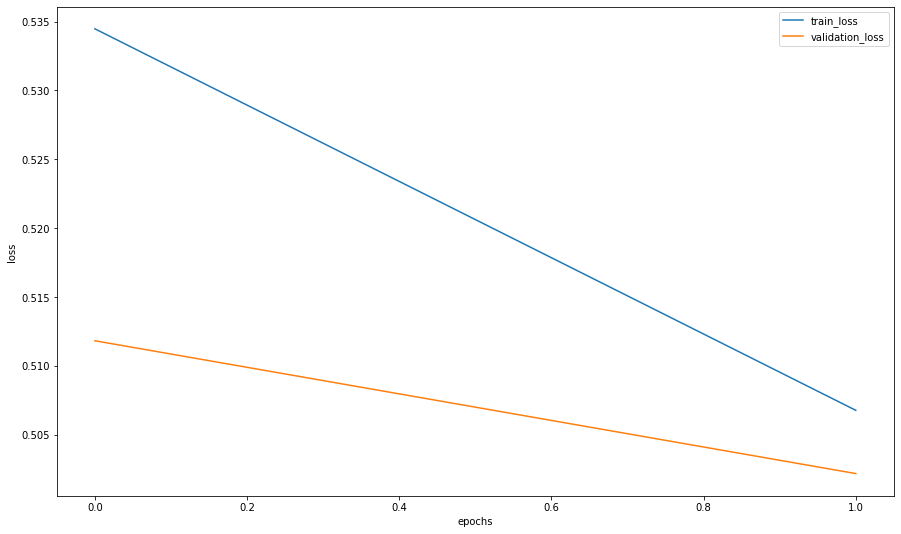

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss_tr, label="train_loss")
plt.plot(loss_test, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Вновь, хоть было всего 2 эпохи, лосс успевает сойтись и при этом модель не переобучается — при увеличении количества эпох переобучение начинает проявляться

Посмотрим качество на тестовом датасете

In [ ]:
test_loader = DataLoader(
    TwitterDataset(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

model.load_state_dict(torch.load("model.pt", map_location=device))

print(testing(model, criterion, test_loader, device=device)[1:])


({'Test Loss': 0.5089631319617312, 'Test Acc': 0.7488268769968051},)


### IDF weights Version

Теперь вместо сложения векторов из матрицы TF-IDF с эмбеддингами соответствующих слов попробуем взвешивать эмбеддинги из Word2Vec с весом, равным IDF — таким образом, часто встречающиеся в текстах корпуса слова будут иметь малый вес и влиять на эмбеддинг предложения меньше, чем более редкие и, возможно, более специфичные, слова. Здесь могла бы возникнуть опасность того, что разного рода "мусор", например, слова с опечатками, будет сильно влиять на эмбеддинг предложения, однако, такого происходить не должно, поскольку слова, которых нет в словаре Word2Vec не будут учитываться (конечно, это может быть не лучший способ борьбы со "странными" словами, однако пока протестируем модель так; в следующем шаге будем смотреть как раз на версию с апгрейдом)

In [ ]:
class TwitterDatasetUPD3(TwitterDataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, 
                 token_func: callable):
        super().__init__(data, feature_column, target_column, word2vec)
        
        # Получаем словарь, сопоставляющий слову его idf
        self.token_func = token_func
        vectorizer = TfidfVectorizer(tokenizer=self.token_func)
        vectorizer.fit_transform(data[feature_column])
        self.idfs = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))


    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"feature": embeddings, "target": label}


    def get_embeddings_(self, tokens):
        embeddings = [((self.word2vec.get_vector(t) - self.mean) / self.std) * 
                      self.idfs[t] 
                      for t in tokens if t in self.word2vec and len(t) > 3]

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(1, -1)

        return embeddings


Датасет нового класса

In [ ]:
dev_upd3 = TwitterDatasetUPD3(dev_data, "text", "emotion", word2vec, token_n_filter)

Посмотрим на распределение векторов случайных текстов разных классов

In [ ]:
indexes = np.arange(len(dev_upd3))
np.random.shuffle(indexes)
example_indexes = indexes[::1000]

examples = {"features": [np.mean(dev_upd3[i]["feature"], axis=0) for i in example_indexes], 
            "targets": [dev_upd3[i]["target"] for i in example_indexes]}
print(len(examples["features"]))

1280


In [ ]:
pca = PCA(n_components=2)
examples["transformed_features"] = pca.fit_transform(examples["features"])

In [ ]:
draw_vectors(
    examples["transformed_features"][:, 0], 
    examples["transformed_features"][:, 1], 
    color=[["red", "blue"][t] for t in examples["targets"]]
    )

Figure(id='1002', ...)

Собственно, вектора текстов разных классов вновь линейно неразделимы

Обучение модели

In [ ]:
batch_size = 1024
num_workers = 4


def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}


train_size = math.ceil(len(dev_upd3) * 0.8)

train, valid = random_split(dev_upd3, [train_size, len(dev_upd3) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

In [ ]:
# Используем те же параметры, что и для первой модели — данный вариант тоже
# хорошо себя с ними показал, да и сравнение разных подходов так значительно 
# облегчается
vector_size = dev_upd3.word2vec.vector_size
num_classes = 2
lr = 1e-4
num_epochs = 2

model = nn.Sequential(
    nn.Linear(vector_size, 512),
    nn.ReLU(),
    nn.Linear(512, 300),
    nn.ReLU(),
    nn.Linear(300, num_classes))

model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=lr) 

In [ ]:
best_metric = np.inf
loss_tr = []
loss_test = []
for e in range(num_epochs):
    train_loss = training(model, optimizer, criterion, train_loader, e, device)
    loss_tr.append(train_loss)
    test_loss, log = testing(model, criterion, valid_loader, device)
    loss_test.append(test_loss)
    print(log)
    if log["Test Loss"] < best_metric:
        torch.save(model.state_dict(), "model.pt")
        best_metric = log["Test Loss"]


{'Test Loss': 0.527984648346901, 'Test Acc': 0.73264453125}



{'Test Loss': 0.5171047602891922, 'Test Acc': 0.740421875}


Посмотрим на графики лоссов

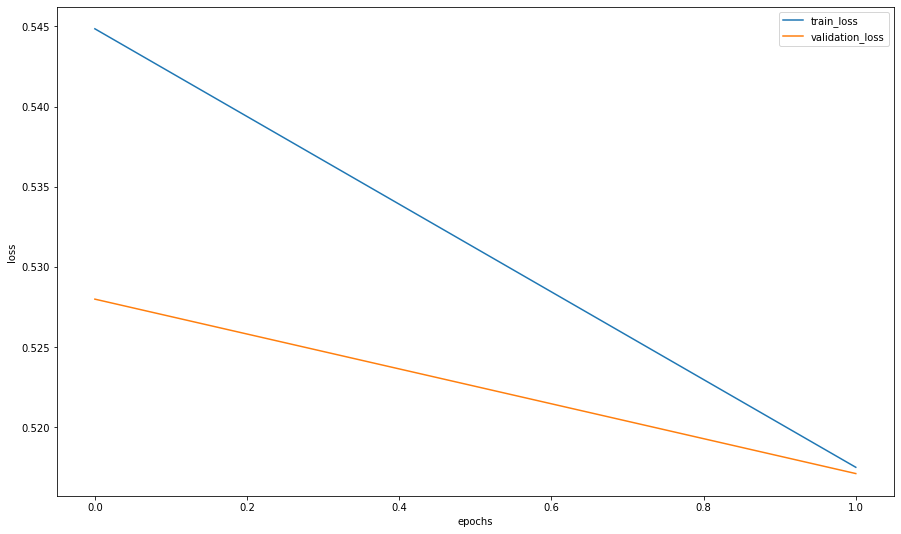

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss_tr, label="train_loss")
plt.plot(loss_test, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Вновь, хоть было всего 2 эпохи, лосс успевает сойтись и при этом модель не переобучается — при увеличении количества эпох переобучение начинает проявляться

Посмотрим качество на тестовом датасете

In [ ]:
test_loader = DataLoader(
    TwitterDataset(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

model.load_state_dict(torch.load("model.pt", map_location=device))

print(testing(model, criterion, test_loader, device=device)[1:])


({'Test Loss': 0.624484970546759, 'Test Acc': 0.7299633087060703},)


### IDF weights + Context Version

Так как взвешивание с помощью IDF не решало возможных проблем со словами, отсутствующими в словаре, попробуем объединить взвешивание и один из методов учёта пропущенных слов, реализованных выше. Конкретно — будем принимать среднее эмбеддингов слов контекста за эмбеддинг данного неизвестного слова. При этом, если слово неизвестное, то домножать его эмбеддинг на idf не будем, поскольку соседи, по которым высчитывается этот самый эмбеддинг, уже были домножены на свои idf. А если неизвестное слово было так же окружено неизвестными словами, это может "взорвать" вектор, сделав его очень большим (т.к. idf редких слов, очевидно, велики).

In [ ]:
class TwitterDatasetUPD4(TwitterDataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, 
                 token_func: callable, window: int=2):
        super().__init__(data, feature_column, target_column, word2vec)
        
        self.window = window
        
        self.token_func = token_func
        vectorizer = TfidfVectorizer(tokenizer=self.token_func)
        vectorizer.fit_transform(data[feature_column])
        self.idfs = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens, self.window)

        return {"feature": embeddings, "target": label}


    def get_embeddings_(self, tokens, window):
        check = sum([int(t in self.word2vec) for t in tokens])
        if not check:
            return np.zeros((1, self.word2vec.vector_size)) 

        embeddings = []
        for i, t in enumerate(tokens):
            if len(t) > 3:
                if t in self.word2vec:
                    emb = (self.word2vec.get_vector(t) - self.mean) / self.std
                    emb *= self.idfs[t]
                else:
                    neibs = tokens[max(0, i-window):i] + tokens[i+1:min(len(tokens), i+window+1)]
                    emb = np.mean(self.get_embeddings_(neibs, window), axis=0)
                
                embeddings.append(emb)

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(1, -1)

        return embeddings

Датасет нового класса

In [ ]:
dev_upd4 = TwitterDatasetUPD4(dev_data, "text", "emotion", word2vec, token_n_filter)

Посмотрим на распределение векторов случайных текстов разных классов

In [ ]:
indexes = np.arange(len(dev_upd4))
np.random.shuffle(indexes)
example_indexes = indexes[::1000]

examples = {"features": [np.mean(dev_upd4[i]["feature"], axis=0) for i in example_indexes], 
            "targets": [dev_upd4[i]["target"] for i in example_indexes]}
print(len(examples["features"]))

1280


In [ ]:
pca = PCA(n_components=2)
examples["transformed_features"] = pca.fit_transform(examples["features"])

In [ ]:
draw_vectors(
    examples["transformed_features"][:, 0], 
    examples["transformed_features"][:, 1], 
    color=[["red", "blue"][t] for t in examples["targets"]]
    )

Figure(id='1108', ...)

Собственно, вектора текстов разных классов вновь линейно неразделимы

Обучение модели

In [ ]:
batch_size = 1024
num_workers = 4


def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}


train_size = math.ceil(len(dev_upd4) * 0.8)

train, valid = random_split(dev_upd4, [train_size, len(dev_upd4) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

In [ ]:
# Используем те же параметры, что и для первой модели — данный вариант тоже
# хорошо себя с ними показал, да и сравнение разных подходов так значительно 
# облегчается
vector_size = dev_upd4.word2vec.vector_size
num_classes = 2
lr = 1e-4
num_epochs = 2

model = nn.Sequential(
    nn.Linear(vector_size, 512),
    nn.ReLU(),
    nn.Linear(512, 300),
    nn.ReLU(),
    nn.Linear(300, num_classes))

model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=lr) 

In [ ]:
best_metric = np.inf
loss_tr = []
loss_test = []
for e in range(num_epochs):
    train_loss = training(model, optimizer, criterion, train_loader, e, device)
    loss_tr.append(train_loss)
    test_loss, log = testing(model, criterion, valid_loader, device)
    loss_test.append(test_loss)
    print(log)
    if log["Test Loss"] < best_metric:
        torch.save(model.state_dict(), "model.pt")
        best_metric = log["Test Loss"]


{'Test Loss': 0.527338574051857, 'Test Acc': 0.734046875}



{'Test Loss': 0.517220447063446, 'Test Acc': 0.74141015625}


Посмотрим на графики лоссов

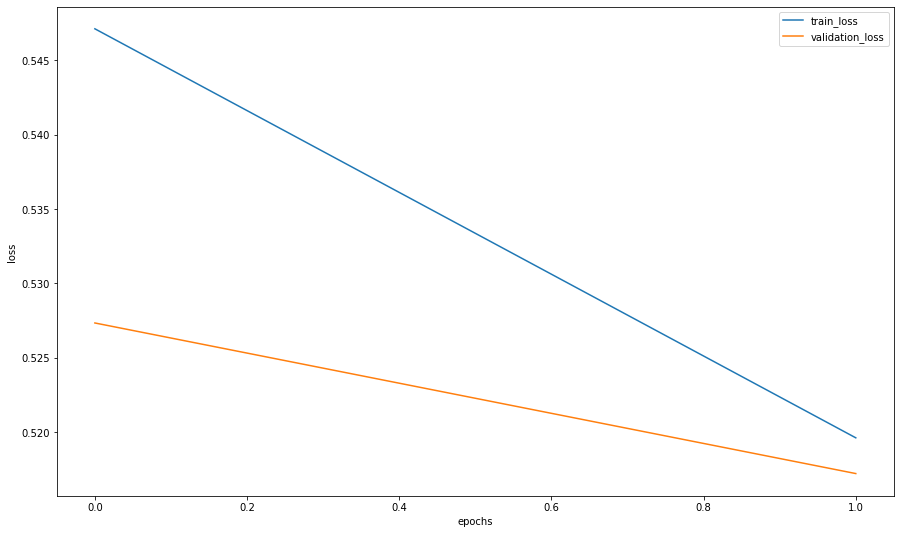

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss_tr, label="train_loss")
plt.plot(loss_test, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Вновь, хоть было всего 2 эпохи, лосс успевает сойтись и при этом модель не переобучается — при увеличении количества эпох переобучение начинает проявляться

Посмотрим качество на тестовом датасете

In [ ]:
test_loader = DataLoader(
    TwitterDataset(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

model.load_state_dict(torch.load("model.pt", map_location=device))

print(testing(model, criterion, test_loader, device=device)[1:])


({'Test Loss': 0.6257828129366183, 'Test Acc': 0.7330521166134185},)


## Итоги

Соберём в одну таблицу результаты разных моделей на тестовом датасете

In [ ]:
cols = [{'Test Loss': 0.506091662203542, 'Test Acc': 0.7486864766373802},
        {'Test Loss': 0.5066267492862555, 'Test Acc': 0.7486147164536742},
        {'Test Loss': 0.5089631319617312, 'Test Acc': 0.7488268769968051},
        {'Test Loss': 0.624484970546759, 'Test Acc': 0.7299633087060703},
        {'Test Loss': 0.6257828129366183, 'Test Acc': 0.7330521166134185}]
indices = ['Average Embedding', 'Context Version', 'TF-IDF Version', 
           'IDF weights Version', 'IDF weights + Context Version']

results = pd.DataFrame(cols, index=indices)

Отсортируем по возрастанию лосса

In [ ]:
results.sort_values(by='Test Loss')

,Test Loss,Test Acc
Average Embedding,0.506092,0.748686
Context Version,0.506627,0.748615
TF-IDF Version,0.508963,0.748827
IDF weights Version,0.624485,0.729963
IDF weights + Context Version,0.625783,0.733052


Отсортируем по убыванию accuracy

In [ ]:
results.sort_values(by='Test Acc', ascending=False)

,Test Loss,Test Acc
TF-IDF Version,0.508963,0.748827
Average Embedding,0.506092,0.748686
Context Version,0.506627,0.748615
IDF weights + Context Version,0.625783,0.733052
IDF weights Version,0.624485,0.729963


Из таблиц видно, что худшее качество как по величине лосса, так и по accuracy, показали модели, использовавшие IDF слов в качестве весов для их эмбеддингов. Предполагаю, что это произошло по следующей причине: весьма вероятно, что различных "сигнальных слов", помогающих распознать эмоциональную окраску текста (например, "happy", "sad" и т.п.), было не так много, особенно с учётом того, что все тексты делились только на позитивные и негативные. Конечно, множество таких слов наверняка велико, но всё же вряд ли многие его элементы были уникальны для всего корпуса текстов. Таким образом, поскольку такие слова встречались хоть и не в каждом тексте, но всё же довольно часто, их веса могли быть сравнительно меньше весов слов, более специфичных для отдельных текстов, но не столь важных для решения поставленной задачи. Из-за этого редкие слова могли сильно "перетягивать" на себя векторы предложений, что затруднило бы определение классов текстов и вылилось в более низкие показатели моделей.  

Кроме того, интересно, что модель, пропускавшая незнакомые слова, показала более низкий лосс и одновременно более низкую accuracy, чем та, которая для получения их эмбеддингов усредняла контекст, что кажется довольно необычным. Тем не менее, замечу, что разница в accuracy очень мала по сравнению с разницей в лоссе (если их вообще корректно сравнивать как 1:1), т.е. на классы текстов, предсказанные моделью как более вероятные, учёт незнакомых слов с помощью контекста почти не повлиял. Если сравнить результаты моделей average и context (которые также отличались только учётом незнакомых слов через контекст), то можно увидеть похожую закономерность — лосс context-модели оказался больше, а accuracy — меньше, чем у average-модели, однако разница в лоссах получилась значительно больше, чем в accuracy. Кажется, что использование "усреднения незнакомых слов по контексту" заметно влияло на уверенность модели, более чувствительным к которой является лосс, нежели accuracy. Если подумать о механизме работы усреднения по контексту, то оно, фактически, увеличивало веса слов, окружающих нечто неизвестное, в эмбеддинге предложения. Вероятно, что в большинстве случаев неизвестные слова были окружены чем попало, а не только лишь "сигнальными словами", по которым можно было бы более-менее однозначно определить класс текста. Таким образом, различные общеупотребимые/не слишком важные слова из-за усреднения по контексту могли получить больший вес и, как следствие, начать сильнее "зашумлять" вектор текста, из-за чего модель становилась бы менее уверенной в предсказаниях, и лосс бы оставался сравнительно выше, чем у аналогичной модели, пропускающей неизвестные слова. Хотя, в определённых пограничных случаях (например, когда модель предсказывала вероятности примерно как 50/50) этот шум и мог подтолкнуть модель к правильному варианту (из-за чего бы accuracy незначительно выросла, как в случае с IDF-моделями).

Двигаясь далее, замечу, что TF-IDF-модель показала себя лучше, чем IDF-модели по обеим метрикам, но при этом и её лосс, и accuracy оказались выше, чем у average и context. Рассуждая о принципе работы данной модели, попробуем описать векторы, которые она "прикладывала" к эмбеддингам слов. Компоненты этих векторов показывали важность конкретного слова для определённого, лексически разнообразного по сравнению с остальными, текста. При этом, скорее всего, большинство из этих векторов были довольно маленькими по норме, однако их суммарный эффект всё же мог иметь определённое влияние на эмбеддинг предложения, при этом никак не соотносясь с эффектом от эмбеддингов из словаря. Эта особенность делает сравнение данной модели с остальными несколько затруднительным, особенно учитывая несколько необычное (или, точнее, "не ожидаемое") соотношение разницы лосса и accuracy данной модели и модели average. Тем не менее, разница в лоссе кажется для меня более значительной и требующей внимания (т.к., как говорилось ранее, она смотрит на "правильную" уверенность модели, а не только конечный результат), да в дополнение является гораздо большей разницы в accuracy. Предположу, что здесь, как и в случае с контекстом, вектора tf-idf могли создавать лишний шум, который бы поубавил уверенность модели (увеличив лосс), но вот на определённых выбросах или пограничных случаях вполне мог подтолкнуть её к правильному результату.

В целом, в случае модели tf-idf для меня достаточно сложно интерпретировать конкретные результаты и анализировать их причины, так что считаю нужным отметить, что и average, и tfidf модели показали себя сравнительно хорошо. Однако, думаю, что имеет смысл остановиться на average модели, т.к. она обучалась быстрее других и требовала меньше памяти, при этом показав лучший лосс (что я считаю наиболее важным) и незначительно уступив tf-idf модели по accuracy. Использование же усреднения по контексту для незнакомых слов, как и применение idf-весов для эмбеддингов, судя по всему, оказалось плохой идеей.

Тем не менее, даже качество рассмотренных моделей по-прежнему оставляет желать лучшего. Возможно, его можно было бы повысить, применяя "правильно" обученные эмбеддинги вместо предобученных на текстах другого корпуса; также нужно отметить, что модели по-прежнему никак не учитывают порядок слов и возможные специфические элементы текстов — сокращённые, сленговые слова и прочее. Кроме того, в рамках своих экспериментов я не нашёл хорошего способа учитывать слова, отсутствующие в словаре, что, наверное, имеет смысл делать. Возможно также есть архитектуры нейросетей и специальные лоссы, позволяющие улучшить качество обучения. В общем, думаю, что есть ещё много моментов, которые можно было бы "подтянуть", однако всё же отмечу, что результаты протестированных здесь моделей получились значительно выше, чем таковые из прошлого ДЗ.